# Desafio 1: Processamento de Dados de ERP de Restaurante

Autor: Marcelo Veras

Data: 25/07/2025

# Introdução

Este notebook documenta a solução para o primeiro Desafio de Engenharia de Dados do Laboratório de Tecnologia do Coco Bambu (CB Lab). O objetivo é processar um arquivo JSON de um ERP, modelar os dados para um banco de dados relacional e justificar a abordagem de design escolhida.

## 1. Descrição do Esquema JSON (ERP.json)

### 1.1. Carregamento e Análise do Esquema JSON

Nesta seção, o arquivo ERP.json é carregado e sua estrutura é explorada para entender o esquema dos dados.

In [3]:
import json
import pandas as pd

file_path = '../data/ERP.json'

with open(file_path, 'r') as f:
    data = json.load(f)

print("Estrutura principal do JSON:")
print(data.keys())

print("\nEstrutura de 'guestChecks':")
guest_check_exemplo = data['guestChecks'][0]
print(guest_check_exemplo.keys())

print("\nEstrutura de 'detailLines':")
detail_line_exemplo = guest_check_exemplo['detailLines'][0]
print(detail_line_exemplo.keys())



Estrutura principal do JSON:
dict_keys(['curUTC', 'locRef', 'guestChecks'])

Estrutura de 'guestChecks':
dict_keys(['guestCheckId', 'chkNum', 'opnBusDt', 'opnUTC', 'opnLcl', 'clsdBusDt', 'clsdUTC', 'clsdLcl', 'lastTransUTC', 'lastTransLcl', 'lastUpdatedUTC', 'lastUpdatedLcl', 'clsdFlag', 'gstCnt', 'subTtl', 'nonTxblSlsTtl', 'chkTtl', 'dscTtl', 'payTtl', 'balDueTtl', 'rvcNum', 'otNum', 'ocNum', 'tblNum', 'tblName', 'empNum', 'numSrvcRd', 'numChkPrntd', 'taxes', 'detailLines'])

Estrutura de 'detailLines':
dict_keys(['guestCheckLineItemId', 'rvcNum', 'dtlOtNum', 'dtlOcNum', 'lineNum', 'dtlId', 'detailUTC', 'detailLcl', 'lastUpdateUTC', 'lastUpdateLcl', 'busDt', 'wsNum', 'dspTtl', 'dspQty', 'aggTtl', 'aggQty', 'chkEmpId', 'chkEmpNum', 'svcRndNum', 'seatNum', 'menuItem'])


### 1.2. O JSON fornecido possui um esquema hierárquico que representa transações de um ponto de venda. A estrutura principal é a seguinte:

#### Objeto Raiz: Contém metadados sobre a carga de dados.
* **curUTC** (String): Timestamp em UTC de quando o dado foi gerado.

* **locRef** (String): Uma referência ou ID da loja/localidade. "99 CB CB".

* **guestChecks** (Array de Objetos): Uma lista contendo um ou mais pedidos.

#### Objeto guestCheck (Pedido): Cada objeto na lista guestChecks representa um único pedido e contém:

* **Identificadores:** guestCheckId (Number), chkNum (Number), empNum (Number), rvcNum (Number), etc.

* **Timestamps:** Diversos campos de data/hora para abertura, fechamento e atualizações (opnBusDt, opnUTC, clsdUTC, etc.).

* **Valores Monetários:** subTtl (Number), chkTtl (Number), dscTtl (Number, pode ser negativo), payTtl (Number).

* **Flags e Contadores:** clsdFlag (Boolean), gstCnt (Number), numSrvcRd (Number).

* **taxes** (Array de Objetos): Uma lista dos impostos aplicados ao pedido. Cada objeto de imposto contém taxNum, txblSlsTtl, taxCollTtl, etc.

* **detailLines** (Array de Objetos): O coração do pedido, representando cada linha de item individual.

#### Objeto detailLine (Linha de Detalhe): Cada objeto na lista detailLines representa um evento ou item no pedido.

* **Identificadores e Metadados:** guestCheckLineItemId (Number), lineNum (Number), detailUTC (String), etc.

* **Valores:** dspTtl (Number), dspQty (Number).

* **MenuItem (Objeto):** Detalhes de um item do cardápio, como miNum (ID do item), modFlag (se foi modificado), inclTax (imposto incluso), etc.

* Conforme o enunciado, aqui também poderiam estar objetos como **discount**, **serviceCharge**, **tenderMedia** ou **errorCode**.

## 2. JSON para Banco de Dados Relacional

### 2.1. Modelagem Conceitual (MER)

A primeira etapa no design de um banco de dados robusto é a **Modelagem Conceitual**. O objetivo desta fase é criar um modelo de alto nível que represente as principais entidades de negócio e como elas se relacionam, sem se preocupar com detalhes técnicos de implementação. A ferramenta utilizada para isso foi o **Modelo Entidade-Relacionamento (MER)**, criado com [Lucidchart](https://www.lucidchart.com/pages/pt/landing?km_CPC_CampaignId=1500131479&km_CPC_AdGroupID=57888677676&km_CPC_Keyword=%2Blucid%20%2Bchart&km_CPC_MatchType=b&km_CPC_ExtensionID=&km_CPC_Network=g&km_CPC_AdPosition=&km_CPC_Creative=286634000551&km_CPC_TargetID=kwd-311590324798&km_CPC_Country=9219142&km_CPC_Device=c&km_CPC_placement=&km_CPC_target=&gad_campaignid=1500131479).

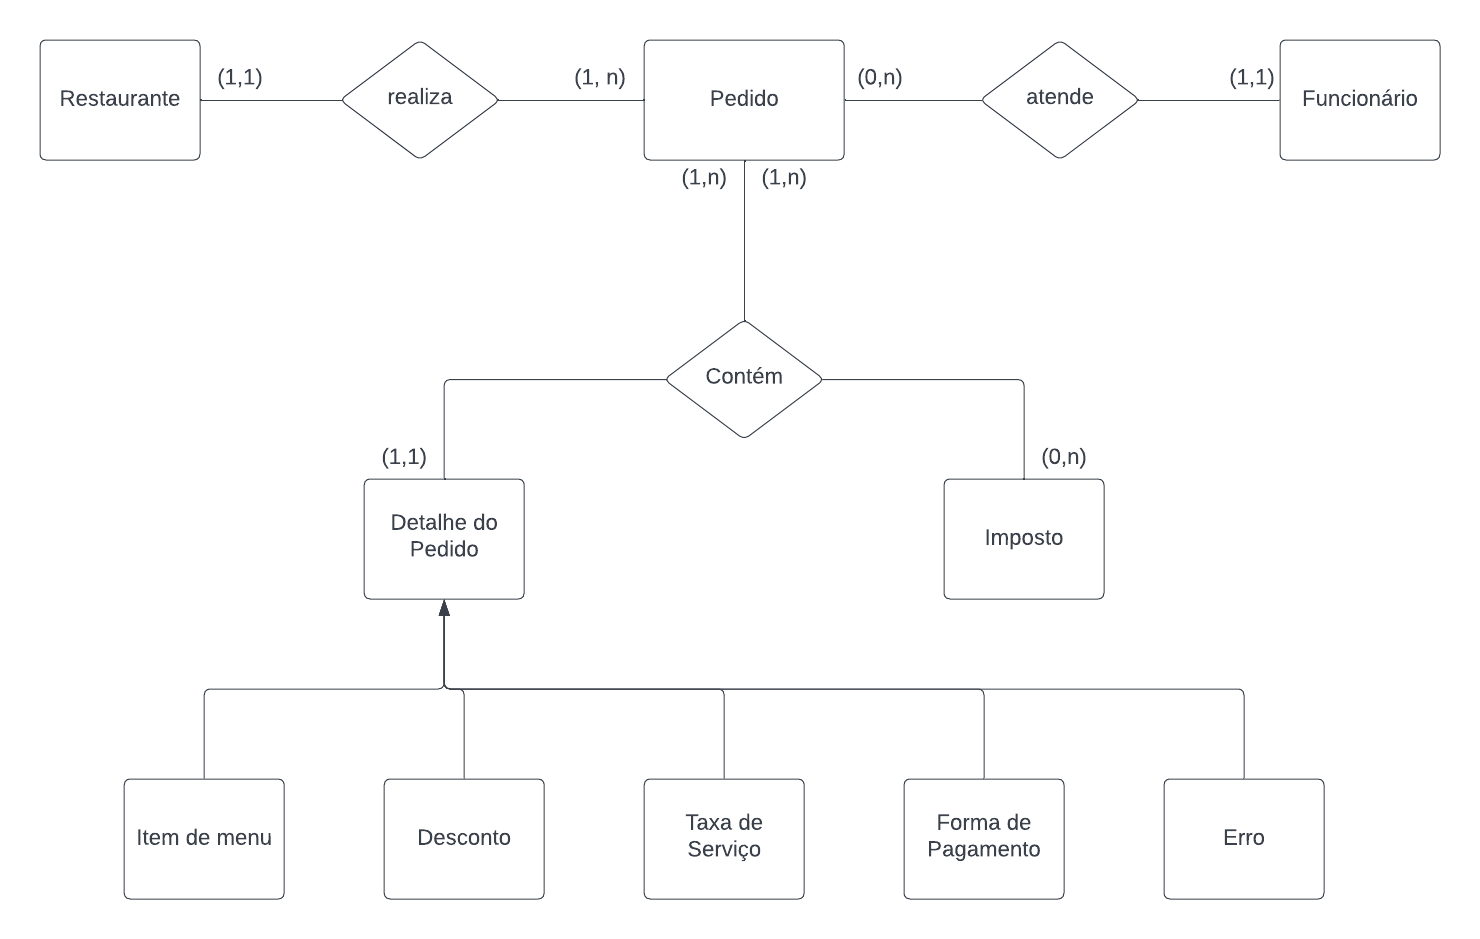

In [5]:
from IPython.display import Image

img = '../assets/MER.png'
Image(filename=img, width=650)

#### Entidades

As seguintes entidades foram identificadas como os pilares do negócio a partir da análise dos dados do ERP:

* **Restaurante:** Representa a unidade da cadeia onde a transação ocorre. (objeto raiz)
* **Funcionário:** A pessoa que atende e é responsável pelo pedido (entidade criada a partir do atributo `empNum` do objeto `guestChecks` por fins de normalização).
* **Pedido:** A entidade central que representa a transação de venda (`guestCheck`).
* **Imposto:** As taxas fiscais que são aplicadas sobre um pedido (`taxes`).
* **Detalhe do Pedido:** Uma entidade genérica que representa cada linha ou evento individual dentro de um pedido (`detailLines`).

#### Generalização e Especialização

A entidade `Detalhe do Pedido` ou `detailLines` é uma **superclasse (ou entidade genérica)**. Ela se especializa nos seguintes subtipos, que representam os diferentes tipos de eventos que podem ocorrer em um pedido:

* **Item de Menu:** Um item do cardápio que foi vendido.
* **Desconto:** Um desconto promocional aplicado.
* **Taxa de Serviço:** Uma taxa adicional, como gorjeta ou couvert.
* **Forma de Pagamento:** O meio utilizado para pagar a conta.
* **Erro:** Um registro de erro ou falha ocorrida durante o processo.

#### Relacionamentos e Cardinalidade

Os relacionamentos definem como as entidades interagem, e a cardinalidade define as regras de negócio dessa interação:

* Um **Restaurante** `realiza` um ou muitos **Pedidos** `(1:N)`.
* Um **Funcionário** `atende` zero ou muitos **Pedidos** `(0:N)`.
* Um **Pedido** `contém` zero ou muitos **Impostos** `(0:N)`.
* Um **Pedido** `contém` um ou muitos **Detalhes do Pedido** `(1:N)`.

### 2.2. Modelagem Lógica (DER)

A etapa de **Modelagem Lógica** transforma o modelo conceitual em um esquema técnico detalhado. O Diagrama Entidade-Relacionamento (DER) abaixo ilustra essa estrutura, detalhando as tabelas, seus atributos, seus datatypes e os relacionamentos através de chaves primárias (PK) e estrangeiras (FK). O DER também foi criado com [Lucidchart](https://www.lucidchart.com/pages/pt/landing?km_CPC_CampaignId=1500131479&km_CPC_AdGroupID=57888677676&km_CPC_Keyword=%2Blucid%20%2Bchart&km_CPC_MatchType=b&km_CPC_ExtensionID=&km_CPC_Network=g&km_CPC_AdPosition=&km_CPC_Creative=286634000551&km_CPC_TargetID=kwd-311590324798&km_CPC_Country=9219142&km_CPC_Device=c&km_CPC_placement=&km_CPC_target=&gad_campaignid=1500131479).

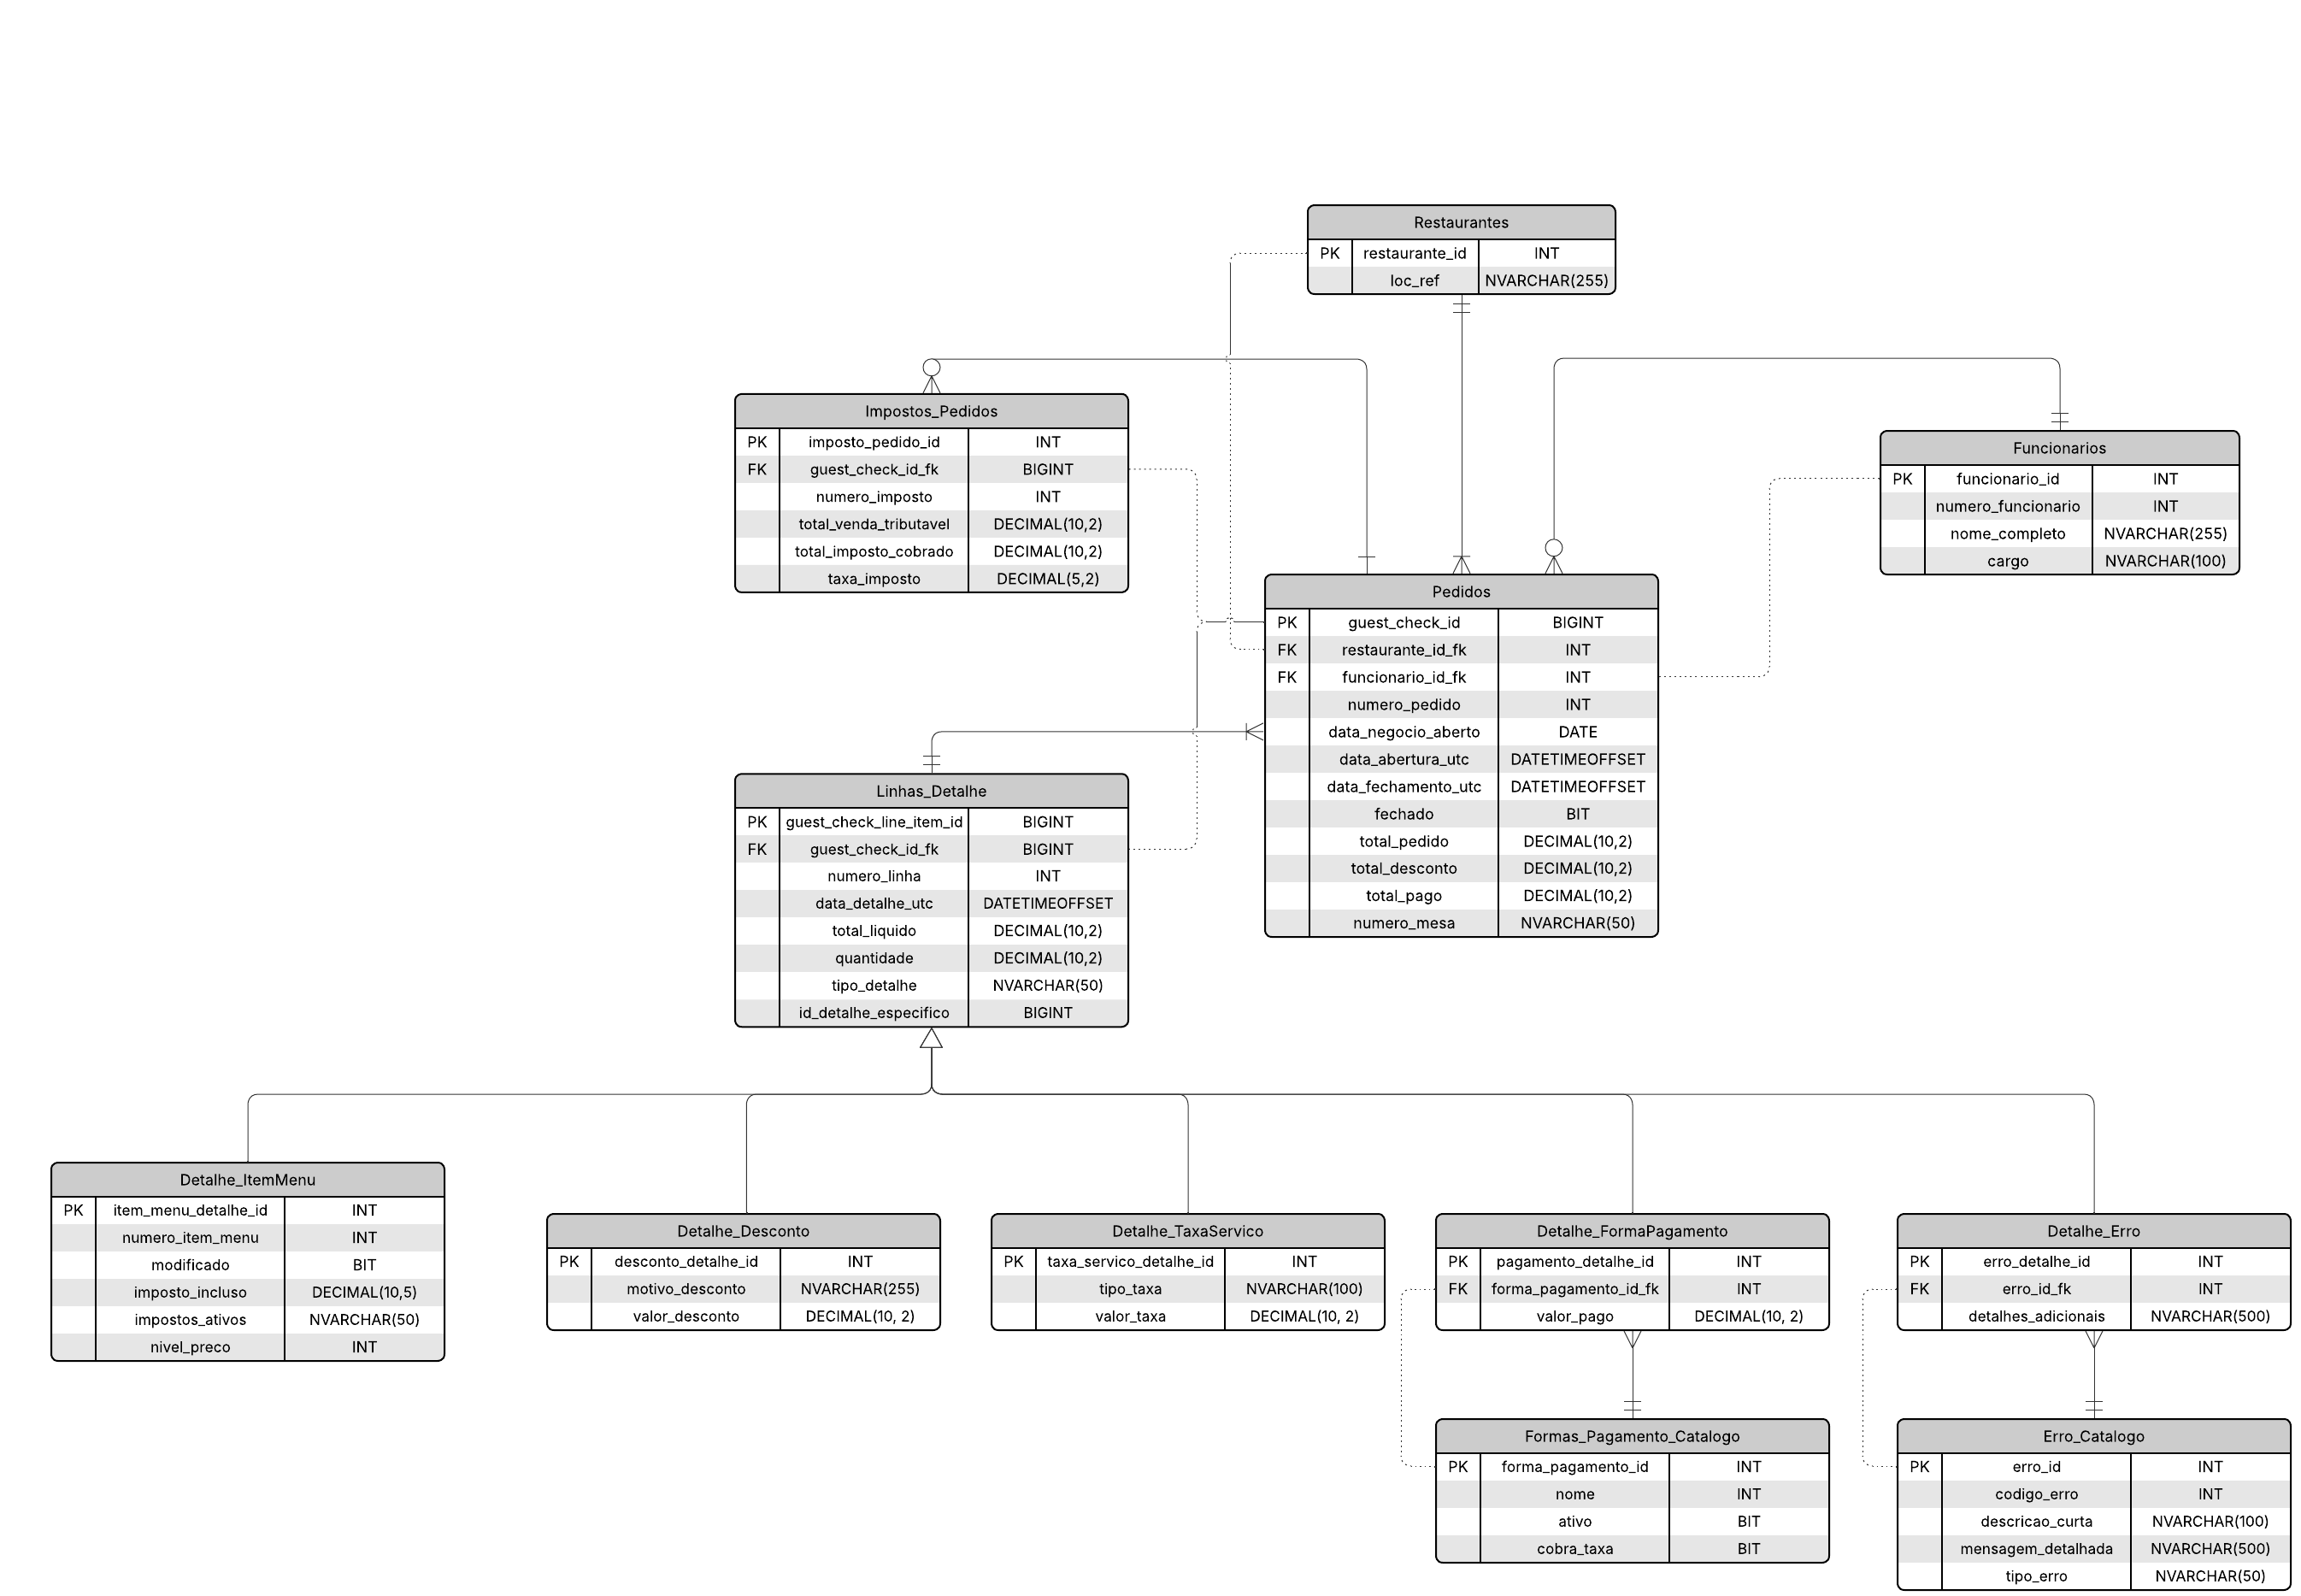

In [6]:
from IPython.display import Image

img = '../assets/DER.png'
Image(filename=img, width=1200)

#### Atributos descartados do arquivo ERP.json para evitar a redundância e garantir a integridade dos dados

#### Novas entidades criadas para assegurar a normalização